<a href="https://colab.research.google.com/github/BabiiIn/NLP/blob/main/%D0%A7%D0%B0%D1%81%D1%82%D1%8C_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Часть 2


Задача:

Обучить несколько моделей рекуррентных нейронных сетей.
Посчитать значение метрики, предложенной в Части 1.
Сравнить результаты для разных RNN, эвристик и классического ML

#Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import spacy
import tensorflow.keras

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.layers import SimpleRNN, BatchNormalization, Embedding
from tensorflow.keras.layers import Flatten, Activation
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import backend as K
from keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

#Чтение данных

Данные предварительно обработаны в рамках выполнения заданий Части 1

In [ ]:
train = pd.read_csv('/content/df.csv').dropna()
train.drop(train.columns[0], axis=1, inplace=True)
train

,text,label
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the covid...,Extremely Negative
...,...,...
40863,airline pilots offering to stock supermarket s...,Neutral
40864,response to complaint not provided citing covi...,Extremely Negative
40865,you know it s getting tough when is rationing ...,Positive
40866,is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
# Смотрим распределение классов

train.label.value_counts()

Positive              11376
Negative               9867
Neutral                7538
Extremely Positive     6615
Extremely Negative     5472
Name: label, dtype: int64

In [ ]:
# Выводим количество категорий для классификации

NUM_CLASSES = len(train.label.value_counts())
print('Количество категорий для классификации: {}'.format(NUM_CLASSES))

Количество категорий для классификации: 5


#Препроцессинг

In [ ]:
# Посчитаем максимальную длинну документа в словах.

descriptions = train['text']
categories = train['label']

MAX_WORDS = 0
for desc in descriptions:
    words = len(desc.split())
    if words > MAX_WORDS:
        MAX_WORDS = words
print('Максимальная длина описания: {} слов'.format(MAX_WORDS))

Максимальная длина описания: 65 слов


(47.0, 65)

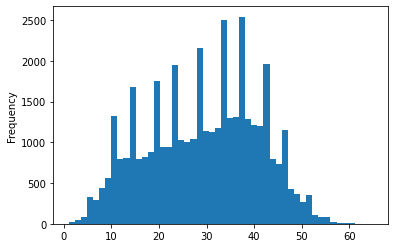

In [ ]:
# Гистограмма распределения длин документов.

lens = train.text.apply(lambda s: len(s.split()))
lens.plot.hist(bins=50)
lens.quantile(0.95), max(lens)

In [ ]:
# Создадим единый словарь (слово -> число) для преобразования.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions.tolist())

# Выясним, с каким количеством слов в словаре мы имеем дело.

total_words = len(tokenizer.word_index)
print('В словаре {} слов'.format(total_words))

В словаре 45818 слов


In [ ]:
# Уменьшим общий словарь, оставив в нем только 10% наиболее популярных слов.

VOCAB_SIZE = round(total_words/10)
VOCAB_SIZE

4582

#Формирование тренировочной и валидационных выборок

In [ ]:
# Создаем тренировочную и валидационную выборки.

X_train, X_test, y_train, y_test = train_test_split(train.text, train.label,
                                                    stratify=train.label,
                                                    test_size=0.2
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32694,), (8174,), (32694,), (8174,))

In [ ]:
# Преобразуем данные для тренировки и валидации в нужный нам формат.

# Разбиваем текст на слова.
print('Преобразуем описания заявок в векторы чисел...')
filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\xa0\ufeff«»'
tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                      filters=filters,
                      lower=True, split=' ', char_level=False
                     )
tokenizer.fit_on_texts(descriptions)

# Преобразуем текст в последовательность чисел
# в соответствии с полученным словарем.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Выравниваем векторы до длины MAX_WORDS.
X_train = pad_sequences(X_train, maxlen=MAX_WORDS)
X_test = pad_sequences(X_test, maxlen=MAX_WORDS)

print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

Преобразуем описания заявок в векторы чисел...
Размерность X_train: (32694, 65)
Размерность X_test: (8174, 65)


In [ ]:
# Преобразуем метки классов в вектора One Hot Encoding.

df_ohe_y_train = y_train.copy()
df_ohe_y_test = y_test.copy()
y_train_ohe = pd.get_dummies(df_ohe_y_train)
y_test_ohe = pd.get_dummies(df_ohe_y_test)

print('Размерность y_train_ohe:', y_train_ohe.shape)
print('Размерность y_test_ohe:', y_test_ohe.shape)

Размерность y_train_ohe: (32694, 5)
Размерность y_test_ohe: (8174, 5)


In [ ]:
# Проверим список классов.

print(list(y_train_ohe.columns))

['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']


In [ ]:
# Для последующего построения confusion matrix
# переводим метки классов в одномерный тензор.

y_test_arr = tf.argmax(y_test_ohe, axis = 1)
len(y_test_arr)

8174

In [ ]:
# Выведем список классов
CLASS_LIST = list(y_test_ohe.columns)
print(type(CLASS_LIST))
print(CLASS_LIST)

<class 'list'>
['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']


# Сборка и обучение моделей

##Применение EarlyStopping Callback

Чтобы избежать переобучения нейронной сети применим EarlyStopping Callback, который остановит процесс обучения нейросети при появлении первых признаков переобучения.

При обучении нейросети мы используем стохастический градиентный спуск или аналогичные методы, при которых качество решения на некоторых эпохах может снижаться, но после этого снова возрастать. Поэтому применим параметр patience = 2, который говорит о том, сколько эпох обучения может ухудшаться метрика качества, прежде чем обучение будет остановлено. Для наших данных ранняя остановка обучения произойдет, если доля правильных ответов на проверочном наборе данных снижается две эпохи подряд.

In [ ]:
# Инициализируем обратный вызов для ранней остановки.
earlystopping = callbacks.EarlyStopping(monitor = "val_loss",
                                        mode = "min", patience = 2,
                                        restore_best_weights = True, verbose =1
                                        )

##Модель 1 LSTM











In [ ]:
K.clear_session()

In [ ]:
# Собираем модель с одним слоем LSTM.

print('Собираем модель...')
model = Sequential()
model.add(Embedding(VOCAB_SIZE, MAX_WORDS))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 65)          297830    
                                                                 
 lstm (LSTM)                 (None, 32)                12544     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 310,539
Trainable params: 310,539
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 16
epochs = 10

print('Тренируем модель...')
history = model.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping]
          )

Тренируем модель...
Epoch 1/10
2044/2044 [==============================] - 164s 79ms/step - loss: 1.2461 - accuracy: 0.4682 - val_loss: 1.0139 - val_accuracy: 0.6046
Epoch 2/10
2044/2044 [==============================] - 163s 80ms/step - loss: 0.9430 - accuracy: 0.6307 - val_loss: 0.9617 - val_accuracy: 0.6242
Epoch 3/10
2044/2044 [==============================] - 159s 78ms/step - loss: 0.8522 - accuracy: 0.6758 - val_loss: 0.9219 - val_accuracy: 0.6479
Epoch 4/10
2044/2044 [==============================] - 162s 79ms/step - loss: 0.7859 - accuracy: 0.7061 - val_loss: 0.9130 - val_accuracy: 0.6505
Epoch 5/10
2044/2044 [==============================] - 161s 79ms/step - loss: 0.7222 - accuracy: 0.7324 - val_loss: 0.9151 - val_accuracy: 0.6548
Epoch 6/10
2044/2044 [==============================] - 163s 80ms/step - loss: 0.6686 - accuracy: 0.7544 - val_loss: 0.9298 - val_accuracy: 0.6555
Epoch 6: early stopping


In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)

Обучение остановлено на эпохе 6


In [ ]:
# По окончанию процесса обучения оценим его результаты.

score = model.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

511/511 [==============================] - 6s 11ms/step - loss: 0.9130 - accuracy: 0.6505

Потери на валидационной выборке: 0.9130057096481323
Доля правильных ответов на валидации: 0.6504771113395691


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.7543891668319702           \nValidation Accuracy: 0.6554930210113525')

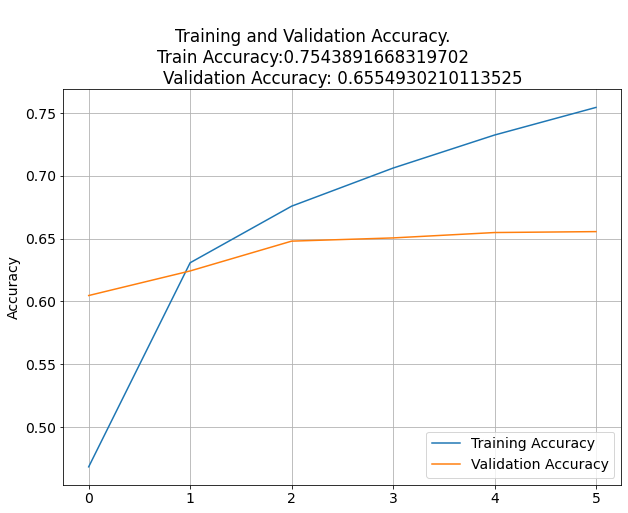

In [ ]:
# Визуализация производительности модели.

# Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

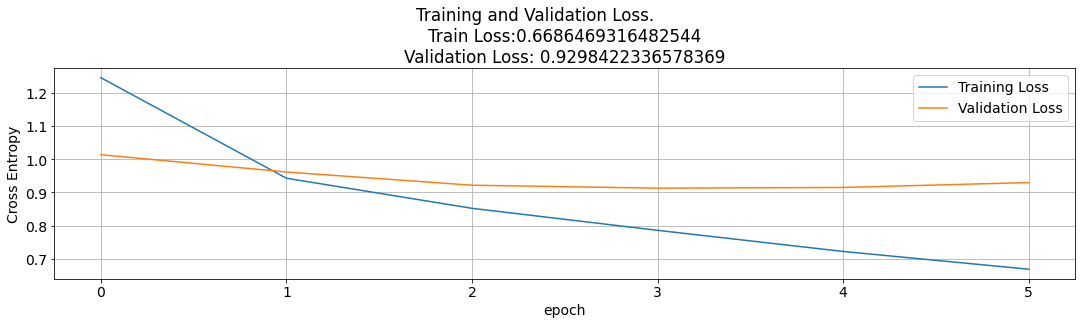

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.

Y_preds = model.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 3s 12ms/step


8174

In [ ]:
y_test_arr

<tf.Tensor: shape=(8174,), dtype=int64, numpy=array([1, 4, 2, ..., 3, 2, 0])>

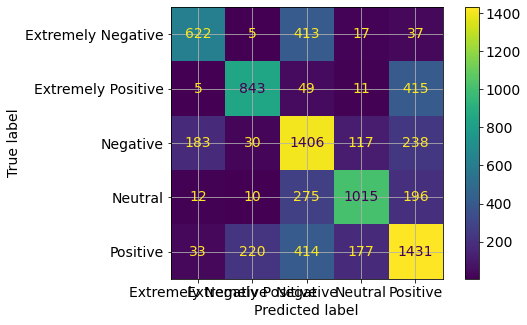

In [ ]:
# Строим confusion matrix.

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1094
           1       0.76      0.64      0.69      1323
           2       0.55      0.71      0.62      1974
           3       0.76      0.67      0.71      1508
           4       0.62      0.63      0.62      2275

    accuracy                           0.65      8174
   macro avg       0.68      0.64      0.66      8174
weighted avg       0.67      0.65      0.65      8174



Результаты

---



В данном варианте $f1-score$ (рассмотрим его как агрегированный показатель качества) составил от $0.66$, accuracy составил 0.65.






##  Модель 2 LSTM


In [ ]:
K.clear_session()

In [ ]:
# Собираем модель.

print('Собираем модель...')
model11 = Sequential()
model11.add(Embedding(VOCAB_SIZE, 128, input_length = MAX_WORDS))
model11.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model11.add(Dropout(0.2))
model11.add(Dense(64, activation='relu'))
model11.add(Dense(NUM_CLASSES, activation='softmax'))

model11.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model11.summary())

Собираем модель...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           582528    
                                                                 
 lstm (LSTM)                 (None, 200)               263200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 858,917
Trainable params: 858,917
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 16
epochs = 10

print('Тренируем модель...')
history = model11.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping]
          )

Тренируем модель...
Epoch 1/10
2044/2044 [==============================] - 465s 223ms/step - loss: 1.2058 - accuracy: 0.4910 - val_loss: 1.0494 - val_accuracy: 0.5800
Epoch 2/10
2044/2044 [==============================] - 444s 217ms/step - loss: 0.9464 - accuracy: 0.6285 - val_loss: 0.9760 - val_accuracy: 0.6180
Epoch 3/10
2044/2044 [==============================] - 450s 220ms/step - loss: 0.8425 - accuracy: 0.6823 - val_loss: 0.9793 - val_accuracy: 0.6271
Epoch 4/10
2044/2044 [==============================] - 449s 220ms/step - loss: 0.7573 - accuracy: 0.7146 - val_loss: 0.9883 - val_accuracy: 0.6269
Epoch 4: early stopping


In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)

Обучение остановлено на эпохе 4


In [ ]:
# По окончанию процесса обучения оценим его результаты.
score = model11.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

511/511 [==============================] - 12s 24ms/step - loss: 0.9760 - accuracy: 0.6180

Потери на валидационной выборке: 0.9759564995765686
Доля правильных ответов на валидации: 0.6180105209350586


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.7145697474479675           \nValidation Accuracy: 0.6269423961639404')

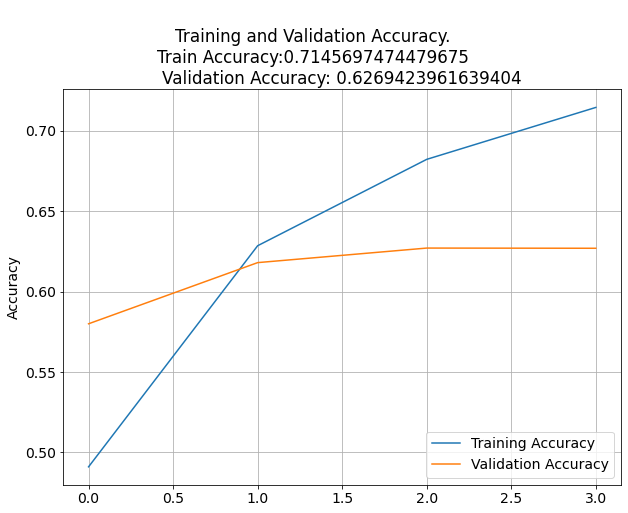

In [ ]:
# Визуализация производительности модели.

# Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

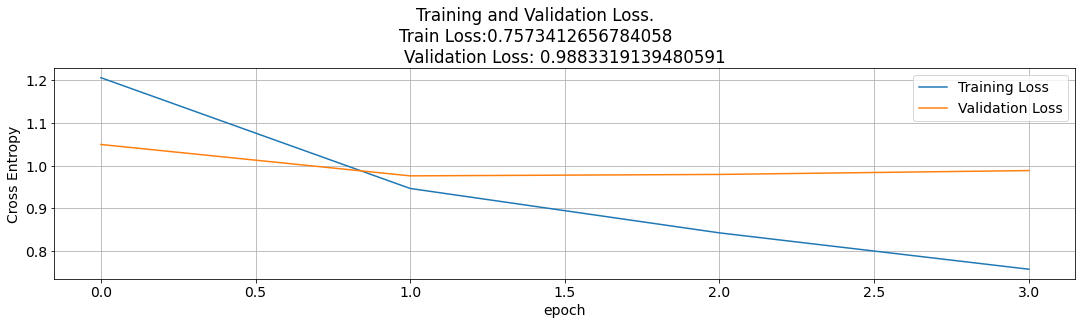

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])} \
          \nValidation Loss: {str(val_loss[-1])}'
)
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.

Y_preds = model11.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 9s 32ms/step


8173

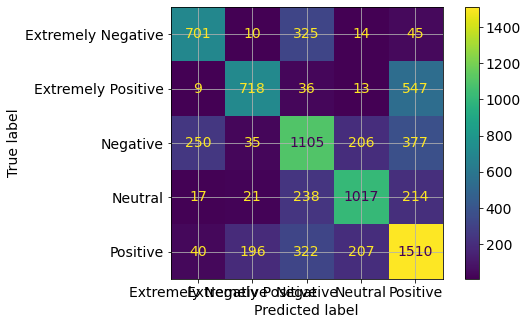

In [ ]:
# Строим confusion matrix.

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66      1095
           1       0.73      0.54      0.62      1323
           2       0.55      0.56      0.55      1973
           3       0.70      0.67      0.69      1507
           4       0.56      0.66      0.61      2275

    accuracy                           0.62      8173
   macro avg       0.65      0.62      0.63      8173
weighted avg       0.63      0.62      0.62      8173



Результаты

---


В данном варианте $f1-score$ (агрегированный показатель качества) составил от $0.63$, accuracy составил 0.62.


## Модель 3 с двумя слоями LSTM

In [ ]:
K.clear_session()

In [ ]:
# Собираем модель.

print('Собираем модель...')
model = Sequential()
model.add(Embedding(VOCAB_SIZE, 128, input_length = MAX_WORDS))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           582528    
                                                                 
 lstm (LSTM)                 (None, 40, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 665,285
Trainable params: 665,285
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
epochs = 10

print('Тренируем модель...')
history = model.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping]
          )

Тренируем модель...
Epoch 1/10
1022/1022 [==============================] - 87s 81ms/step - loss: 1.2206 - accuracy: 0.4895 - val_loss: 1.0647 - val_accuracy: 0.5667
Epoch 2/10
1022/1022 [==============================] - 76s 75ms/step - loss: 0.9701 - accuracy: 0.6289 - val_loss: 0.9876 - val_accuracy: 0.6074
Epoch 3/10
1022/1022 [==============================] - 72s 70ms/step - loss: 0.8824 - accuracy: 0.6721 - val_loss: 1.0005 - val_accuracy: 0.6154
Epoch 4/10
1022/1022 [==============================] - 72s 71ms/step - loss: 0.7999 - accuracy: 0.7074 - val_loss: 0.9799 - val_accuracy: 0.6140
Epoch 5/10
1022/1022 [==============================] - 74s 72ms/step - loss: 0.7249 - accuracy: 0.7433 - val_loss: 1.0275 - val_accuracy: 0.6105
Epoch 6/10
1022/1022 [==============================] - 72s 71ms/step - loss: 0.6544 - accuracy: 0.7699 - val_loss: 1.0856 - val_accuracy: 0.6127
Epoch 6: early stopping


In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)

Обучение остановлено на эпохе 6


In [ ]:
# По окончанию процесса обучения оценим его результаты.
score = model.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

256/256 [==============================] - 5s 20ms/step - loss: 0.9799 - accuracy: 0.6140

Потери на валидационной выборке: 0.9798969626426697
Доля правильных ответов на валидации: 0.6139728426933289


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.7698755264282227           \nValidation Accuracy: 0.6127492785453796')

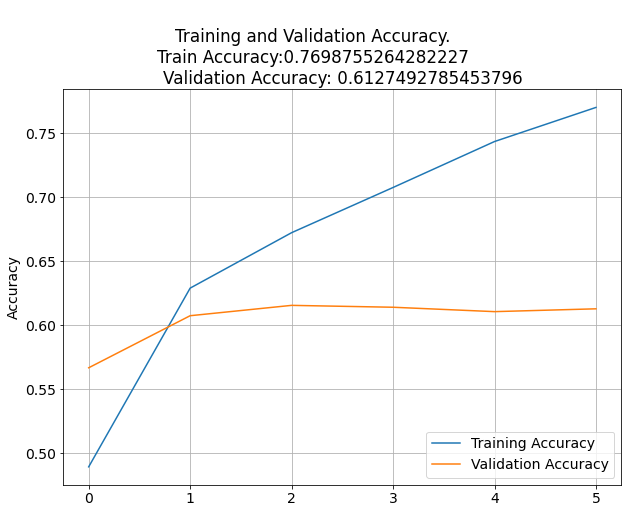

In [ ]:
# Визуализация производительности модели.

#  Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

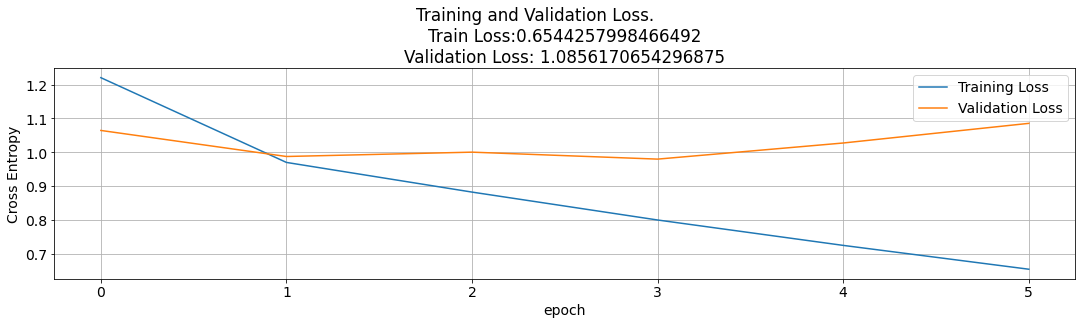

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.

Y_preds = model.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 6s 19ms/step


8173

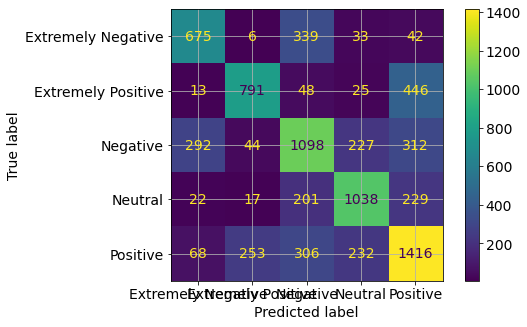

In [ ]:
# Строим confusion matrix.

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1095
           1       0.71      0.60      0.65      1323
           2       0.55      0.56      0.55      1973
           3       0.67      0.69      0.68      1507
           4       0.58      0.62      0.60      2275

    accuracy                           0.61      8173
   macro avg       0.63      0.62      0.62      8173
weighted avg       0.62      0.61      0.61      8173



Результаты

---


В данном варианте $f1-score$ (агрегированный показатель качества) составил от $0.62$, accuracy составил 0.61.


##Модель 4 с 2 слоями LSTM



In [ ]:
K.clear_session()

In [ ]:
# Собираем модель.

print('Собираем модель...')
model2 = Sequential()
model2.add(Embedding(VOCAB_SIZE, 128, input_length = MAX_WORDS))
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, activation = 'tanh',
               return_sequences=True))
model2.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, activation='tanh'))
model2.add(Dense(NUM_CLASSES, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model2.summary())

Собираем модель...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           582528    
                                                                 
 lstm (LSTM)                 (None, 40, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 644,517
Trainable params: 644,517
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 16
epochs = 15

print(u'Тренируем модель...')
history = model2.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping]
          )

Тренируем модель...
Epoch 1/15
2044/2044 [==============================] - 237s 113ms/step - loss: 1.1820 - accuracy: 0.5032 - val_loss: 1.0075 - val_accuracy: 0.5976
Epoch 2/15
2044/2044 [==============================] - 227s 111ms/step - loss: 0.9342 - accuracy: 0.6378 - val_loss: 0.9891 - val_accuracy: 0.6178
Epoch 3/15
2044/2044 [==============================] - 226s 110ms/step - loss: 0.8500 - accuracy: 0.6813 - val_loss: 0.9535 - val_accuracy: 0.6321
Epoch 4/15
2044/2044 [==============================] - 225s 110ms/step - loss: 0.7714 - accuracy: 0.7165 - val_loss: 0.9702 - val_accuracy: 0.6268
Epoch 5/15
2044/2044 [==============================] - 228s 112ms/step - loss: 0.6958 - accuracy: 0.7482 - val_loss: 1.0195 - val_accuracy: 0.6268
Epoch 5: early stopping


In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)


Обучение остановлено на эпохе 5


In [ ]:
# По окончанию процесса обучения оценим его результаты.
score = model2.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

511/511 [==============================] - 7s 15ms/step - loss: 0.9535 - accuracy: 0.6321

Потери на валидационной выборке: 0.953467845916748
Доля правильных ответов на валидации: 0.6320812702178955


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.7482181787490845           \nValidation Accuracy: 0.6268200278282166')

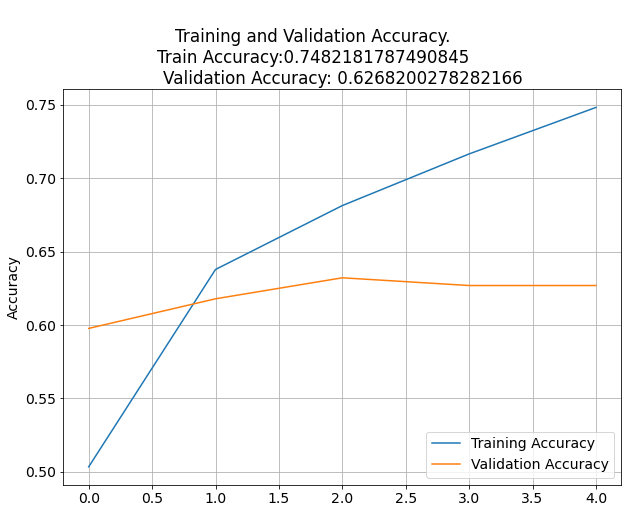

In [ ]:
# Визуализация производительности модели.

# Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

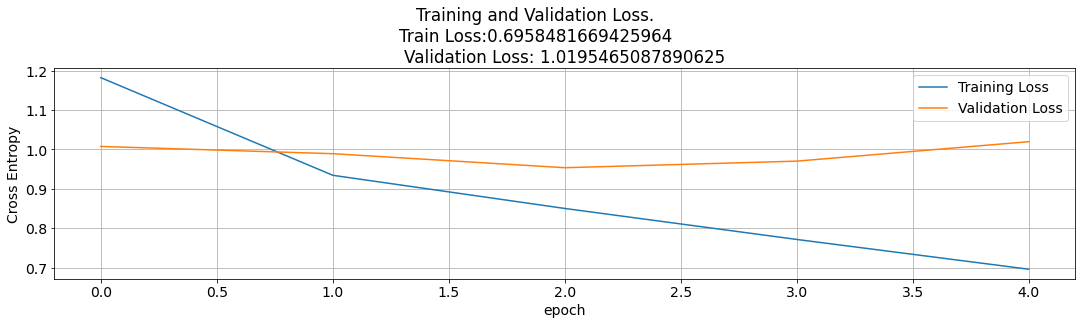

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])} \
          \nValidation Loss: {str(val_loss[-1])}'
)
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.

Y_preds = model2.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 5s 18ms/step


8173

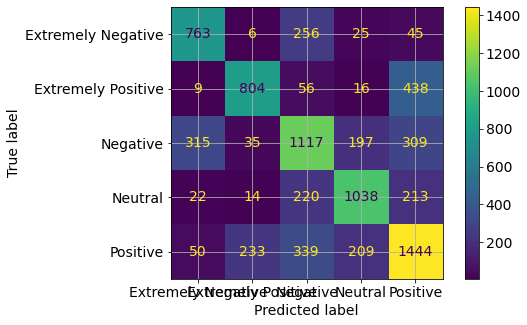

In [ ]:
# Строим confusion matrix.
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1095
           1       0.74      0.61      0.67      1323
           2       0.56      0.57      0.56      1973
           3       0.70      0.69      0.69      1507
           4       0.59      0.63      0.61      2275

    accuracy                           0.63      8173
   macro avg       0.65      0.64      0.64      8173
weighted avg       0.64      0.63      0.63      8173



Результаты

---


В данном варианте $f1-score$ (агрегированный показатель качества) составил от $0.64$, accuracy составил 0.63.



## Модель 5 со слоями RNN, LSTM


In [ ]:
K.clear_session()

In [ ]:
# Собираем модель.

model3 = Sequential()
model3.add(Embedding(VOCAB_SIZE, 256, input_length = MAX_WORDS))
model3.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2,
                     activation='tanh', return_sequences=True))
model3.add(LSTM(64, activation='tanh', return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(32, activation='tanh'))
model3.add(Dense(64, activation='tanh'))
model3.add(Dropout(0.5))
model3.add(Dense(NUM_CLASSES, activation='softmax'))


model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 256)           1165056   
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 128)           49280     
                                                                 
 lstm (LSTM)                 (None, 40, 64)            49408     
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
batch_size = 16
epochs = 15

print('Тренируем модель...')
history = model3.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping]
          )

Тренируем модель...
Epoch 1/15
2044/2044 [==============================] - 194s 92ms/step - loss: 1.3803 - accuracy: 0.3852 - val_loss: 1.1376 - val_accuracy: 0.5196
Epoch 2/15
2044/2044 [==============================] - 181s 88ms/step - loss: 1.0573 - accuracy: 0.5776 - val_loss: 1.0270 - val_accuracy: 0.5989
Epoch 3/15
2044/2044 [==============================] - 181s 88ms/step - loss: 0.9748 - accuracy: 0.6246 - val_loss: 0.9934 - val_accuracy: 0.6120
Epoch 4/15
2044/2044 [==============================] - 182s 89ms/step - loss: 0.9180 - accuracy: 0.6545 - val_loss: 0.9764 - val_accuracy: 0.6224
Epoch 5/15
2044/2044 [==============================] - 182s 89ms/step - loss: 0.8757 - accuracy: 0.6761 - val_loss: 0.9655 - val_accuracy: 0.6266
Epoch 6/15
2044/2044 [==============================] - 183s 90ms/step - loss: 0.8456 - accuracy: 0.6936 - val_loss: 0.9677 - val_accuracy: 0.6306
Epoch 7/15
2044/2044 [==============================] - 184s 90ms/step - loss: 0.8199 - accuracy: 

In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)


Обучение остановлено на эпохе 9


In [ ]:
# По окончанию процесса обучения оценим его результаты.
score = model3.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

511/511 [==============================] - 9s 17ms/step - loss: 0.9648 - accuracy: 0.6323

Потери на валидационной выборке: 0.9647969603538513
Доля правильных ответов на валидации: 0.6323259472846985


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.7305068969726562           \nValidation Accuracy: 0.6359965801239014')

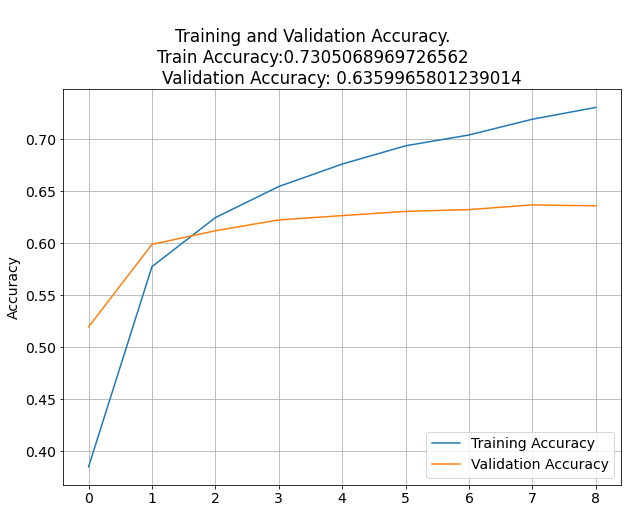

In [ ]:
# Визуализация производительности модели.

# Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

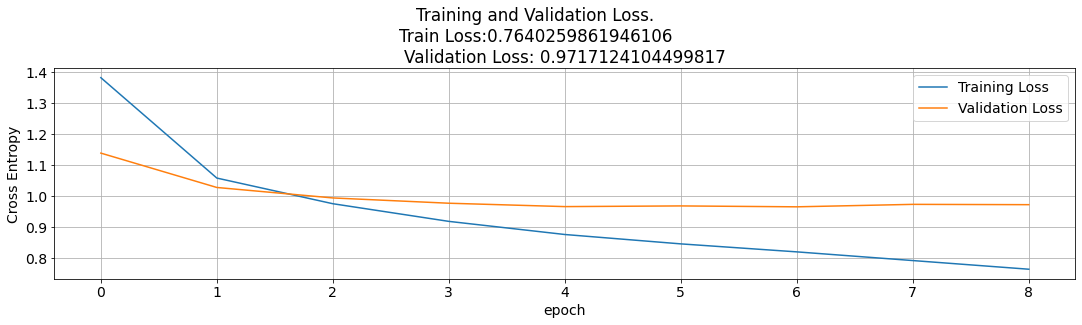

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])} \
          \nValidation Loss: {str(val_loss[-1])}'
)
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.

Y_preds = model3.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 7s 23ms/step


8173

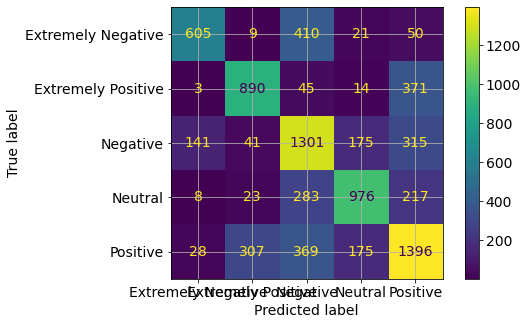

In [ ]:
# Строим confusion matrix.
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.77      0.55      0.64      1095
           1       0.70      0.67      0.69      1323
           2       0.54      0.66      0.59      1973
           3       0.72      0.65      0.68      1507
           4       0.59      0.61      0.60      2275

    accuracy                           0.63      8173
   macro avg       0.66      0.63      0.64      8173
weighted avg       0.64      0.63      0.63      8173



Результаты

---


В данном варианте $f1-score$ (агрегированный показатель качества) составил от $0.64$, accuracy составил 0.63.



## Модель 6 со слоем GRU



In [ ]:
K.clear_session()

In [ ]:
# Собираем модель.

print(u'Собираем модель...')
model4 = Sequential()
model4.add(Embedding(VOCAB_SIZE, 256, input_length = MAX_WORDS))
model4.add(GRU(128, dropout=0.2, recurrent_dropout=0.2,
               activation = 'tanh', return_sequences=True))
model4.add(SimpleRNN(128, activation='tanh', return_sequences=True))
model4.add(SimpleRNN(64, activation='tanh'))
model4.add(Dense(32, activation='tanh'))
model4.add(Dropout(0.5))
model4.add(Dense(NUM_CLASSES, activation='softmax'))

model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model4.summary())



Собираем модель...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 65, 256)           1172992   
                                                                 
 gru (GRU)                   (None, 65, 128)           148224    
                                                                 
 simple_rnn (SimpleRNN)      (None, 65, 128)           32896     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 5

In [ ]:
batch_size = 16
epochs = 15

print('Тренируем модель...')
history = model4.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping]
          )

Тренируем модель...
Epoch 1/15
2044/2044 [==============================] - 565s 273ms/step - loss: 1.6269 - accuracy: 0.2510 - val_loss: 1.5766 - val_accuracy: 0.2783
Epoch 2/15
2044/2044 [==============================] - 536s 262ms/step - loss: 1.5823 - accuracy: 0.2722 - val_loss: 1.5775 - val_accuracy: 0.2783
Epoch 3/15
2044/2044 [==============================] - 531s 260ms/step - loss: 1.5788 - accuracy: 0.2727 - val_loss: 1.5764 - val_accuracy: 0.2783
Epoch 4/15
2044/2044 [==============================] - 532s 260ms/step - loss: 1.5771 - accuracy: 0.2770 - val_loss: 1.5762 - val_accuracy: 0.2783
Epoch 5/15
2044/2044 [==============================] - 532s 260ms/step - loss: 1.5770 - accuracy: 0.2757 - val_loss: 1.5759 - val_accuracy: 0.2783
Epoch 6/15
2044/2044 [==============================] - 527s 258ms/step - loss: 1.5775 - accuracy: 0.2754 - val_loss: 1.5752 - val_accuracy: 0.2783
Epoch 7/15
2044/2044 [==============================] - 533s 261ms/step - loss: 1.5773 - acc

In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)

Обучение остановлено на эпохе 8


In [ ]:
# По окончанию процесса обучения оценим его результаты.
score = model4.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

511/511 [==============================] - 15s 30ms/step - loss: 1.5752 - accuracy: 0.2783

Потери на валидационной выборке: 1.5751954317092896
Доля правильных ответов на валидации: 0.2783215045928955


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.27592217922210693           \nValidation Accuracy: 0.2783215045928955')

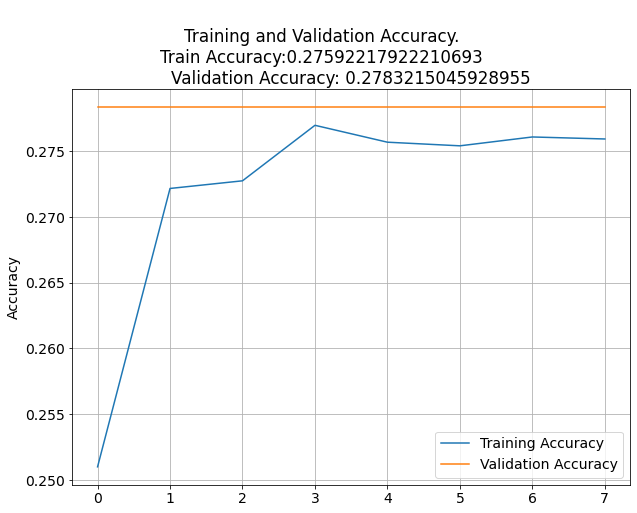

In [ ]:
# Визуализация производительности модели.

# Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

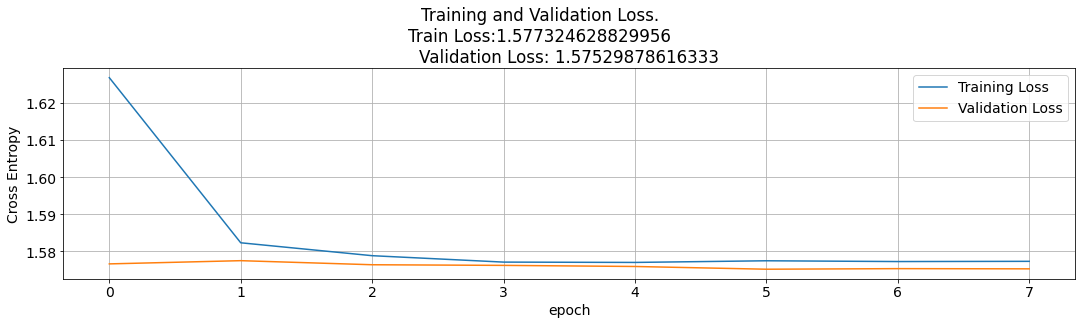

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])} \
          \nValidation Loss: {str(val_loss[-1])}'
)
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.
Y_preds = model4.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 11s 41ms/step


8174

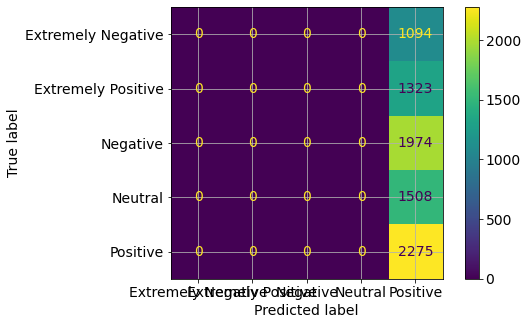

In [ ]:
# Строим confusion matrix.
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1094
           1       0.00      0.00      0.00      1323
           2       0.00      0.00      0.00      1974
           3       0.00      0.00      0.00      1508
           4       0.28      1.00      0.44      2275

    accuracy                           0.28      8174
   macro avg       0.06      0.20      0.09      8174
weighted avg       0.08      0.28      0.12      8174



Результаты

---


В данном варианте $f1-score$ (агрегированный показатель качества) составил от $0.09$, accuracy составил 0.28.


## Модель 7 Bidirectional LSTM


In [ ]:
K.clear_session()

In [ ]:
# Собираем модель.

print('Собираем модель...')
model5 = Sequential()
model5.add(Embedding(VOCAB_SIZE, 256, input_length = MAX_WORDS))
model5.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2,
                              activation = 'tanh', return_sequences=True)))
model5.add(Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.2,
                              activation='tanh')))
model5.add(Dense(NUM_CLASSES, activation='softmax'))

model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model5.summary())

Собираем модель...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 256)           1165056   
                                                                 
 bidirectional (Bidirectiona  (None, 40, 128)          164352    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1,370,949
Trainable params: 1,370,949
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
epochs = 15

print('Тренируем модель...')
history = model5.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test_ohe),
          callbacks = [earlystopping])

Тренируем модель...
Epoch 1/15
1022/1022 [==============================] - 323s 305ms/step - loss: 1.1999 - accuracy: 0.4925 - val_loss: 1.0336 - val_accuracy: 0.5874
Epoch 2/15
1022/1022 [==============================] - 314s 307ms/step - loss: 0.9485 - accuracy: 0.6288 - val_loss: 0.9870 - val_accuracy: 0.6169
Epoch 3/15
1022/1022 [==============================] - 313s 306ms/step - loss: 0.8659 - accuracy: 0.6729 - val_loss: 0.9688 - val_accuracy: 0.6187
Epoch 4/15
1022/1022 [==============================] - 312s 305ms/step - loss: 0.7999 - accuracy: 0.7005 - val_loss: 0.9807 - val_accuracy: 0.6278
Epoch 5/15
1022/1022 [==============================] - 312s 305ms/step - loss: 0.7302 - accuracy: 0.7309 - val_loss: 1.0148 - val_accuracy: 0.6207
Epoch 5: early stopping


In [ ]:
print("Обучение остановлено на эпохе", earlystopping.stopped_epoch+1)

Обучение остановлено на эпохе 5


In [ ]:
# По окончанию процесса обучения оценим его результаты.
score = model5.evaluate(X_test, y_test_ohe,
                       batch_size=batch_size, verbose=1)
print()
print('Потери на валидационной выборке: {}'.format(score[0]))
print('Доля правильных ответов на валидации: {}'.format(score[1]))

256/256 [==============================] - 9s 36ms/step - loss: 0.9688 - accuracy: 0.6187

Потери на валидационной выборке: 0.9687946438789368
Доля правильных ответов на валидации: 0.6187446713447571


Text(0.5, 1.0, '\nTraining and Validation Accuracy.           \nTrain Accuracy:0.7309045195579529           \nValidation Accuracy: 0.62070232629776')

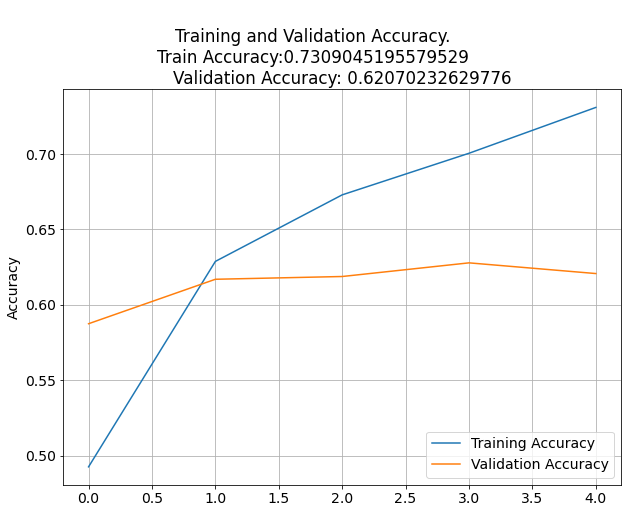

In [ ]:
# Визуализация производительности модели.

# Store results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot results.
# Accuracy.
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \
          \nTrain Accuracy:{str(acc[-1])} \
          \nValidation Accuracy: {str(val_acc[-1])}'
)

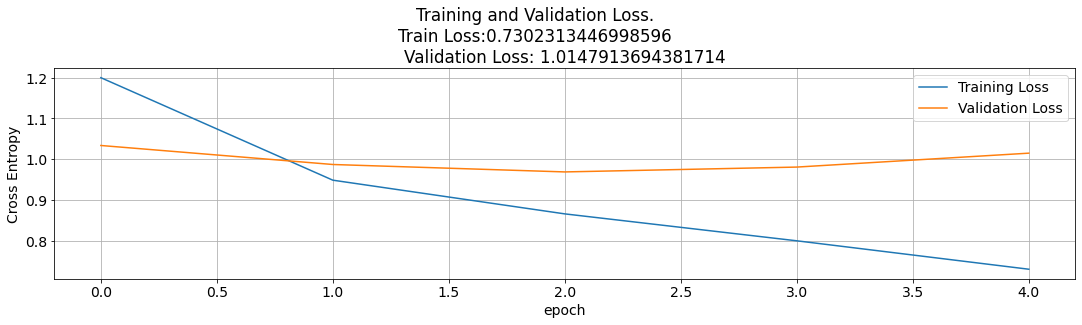

In [ ]:
# Plot results.
# Loss.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \
          \nTrain Loss:{str(loss[-1])} \
          \nValidation Loss: {str(val_loss[-1])}'
)
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Делаем предсказание.
Y_preds = model5.predict(X_test).argmax(axis=-1)
len(Y_preds)

256/256 [==============================] - 10s 36ms/step


8173

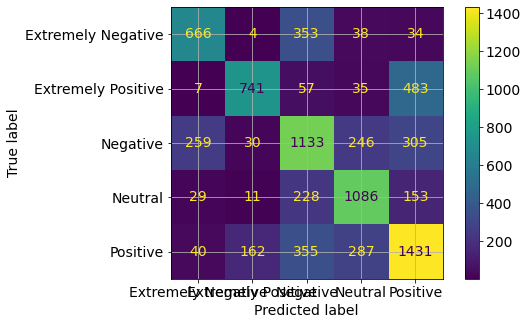

In [ ]:
# Строим confusion matrix.
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_arr, Y_preds),
    display_labels=CLASS_LIST,
)
cmp.plot(ax=ax)
plt.show();

In [ ]:
# Выводим classification report.

print(classification_report(y_test_arr, Y_preds))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1095
           1       0.78      0.56      0.65      1323
           2       0.53      0.57      0.55      1973
           3       0.64      0.72      0.68      1507
           4       0.59      0.63      0.61      2275

    accuracy                           0.62      8173
   macro avg       0.64      0.62      0.63      8173
weighted avg       0.63      0.62      0.62      8173



Результаты

---


В данном варианте $f1-score$ (агрегированный показатель качества) составил от $0.63$, accuracy составил 0.62.



#Итоги работы рассмотренных моделей

Подведем итоги работы моделей, сравнив полученные значения агрегированного показателя качества - $f1-score$ и accuracy.


In [ ]:
# Выведем таблицу сравнительных результатов работы моделей.

table=pd.DataFrame(columns = ['Accuracy', 'f1-score'],
                   index = ['Модель 1 LSTM', 'Модель 2 LSTM',
                            'Модель 3 с двумя LSTM', 'Модель 4 с двумя LSTM',
                            'Модель 5 с RNN,LSTM', 'Модель 6 с GRU',
                            'Модель 7 Bidirectional LSTM', 'SGDClassifier',
                            'Наивная Модель'
                           ]
                  )

In [ ]:
table.loc['Модель 1 LSTM'] = [0.65, 0.66]
table.loc['Модель 2 LSTM'] = [0.62, 0.63]
table.loc['Модель 3 с двумя LSTM'] = [0.61, 0.62]
table.loc['Модель 4 с двумя LSTM'] = [0.63, 0.64]
table.loc['Модель 5 с RNN,LSTM'] = [0.63, 0.64]
table.loc['Модель 6 с GRU'] = [0.28, 0.09]
table.loc['Модель 7 Bidirectional LSTM'] = [0.62, 0.63]
table.loc['SGDClassifier'] = [0.54, 0.54]
table.loc['Наивная Модель'] = [0.20, 0.09]

In [ ]:
table

,Accuracy,f1-score
Модель 1 LSTM,0.65,0.66
Модель 2 LSTM,0.62,0.63
Модель 3 с двумя LSTM,0.61,0.62
Модель 4 с двумя LSTM,0.63,0.64
"Модель 5 с RNN,LSTM",0.63,0.64
Модель 6 с GRU,0.28,0.09
Модель 7 Bidirectional LSTM,0.62,0.63
SGDClassifier,0.54,0.54
Наивная Модель,0.2,0.09


Как видно из таблицы сравнительных результатов лучшие результаты продемонстрировали модели *рекуррентных нейронных сетей*. При этом результативность моделей рекуррентных нейронных сетей находится примерно на одном уровне (за исключением результатов модели GRU).  


Чуть хуже результаты у классической модели  ML - $SGDClassifier$ и совсем неудовлетврительные результаты у Модели с наивными методами классификации (без использования ML и нейронных сетей).


Среди рекуррентных нейронных сетей лучшие результаты достигнуты Моделью 1 с LSTM.  


В качестве метрики для сравнения качества работы моделей  использован агрегированный критерий качества (объединяющий precision и recal, их среднее гармоническое) - F-мера. Данная метрика принята во внимание ввиду того, что в нашем примере классы не сбалансированы, и показатель accuracy будет давать неверную оценку работы модели в части прогнозирования для классов меньшинства.  

Показатель accuracy приведен справочно исходя из условий задачи по достижению необходимого значения данным показателем.

# GloVe Model

В связи с тем, что мы недостили необходимой метрики качества (accuracy >= 70%) попробуем применить предварительно обученные векторные представления слов в модели GloVe.

Применим векторные представления на трех основных типах RNN: SimpleRNN, Long-Short Term Memories (LSTM) и Gated Recurrent Units (GRU).

##Определение вспомогательных функций

Вспомогательная функция def load_glove_model загрузит модель встраивания твиттера, которую необходимо скачать. Эта модель обучена на большом количестве твитов.

In [ ]:
def load_glove_model(glove_file):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model
# adopted from utils.py
nlp = spacy.blank("en")
# nlp = spacy.load("en")

Подготовка и предобработка данных

In [ ]:
# Посчитаем максимальную длинну документа в словах
descriptions = train['text']
categories = train['label']

# Посчитаем максимальную длинну текста описания в словах
max_words = 0
for desc in descriptions:
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальная длина описания: {} слов'.format(max_words))

Максимальная длина описания: 65 слов


In [ ]:
data_X = train["text"].to_numpy()
data_y = train["label"]
data_y = pd.get_dummies(data_y).to_numpy()

Следующая ячейка кода преобразует текст твита в формат последовательности, который будет передан в RNN

In [ ]:
# load the glove model
glove_model = load_glove_model("glove.twitter.27B.200d.txt")
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 64

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

[INFO]Loading GloVe Model...
[INFO] Done...563597 words loaded!
Found 45818 unique tokens.


##Формирование тренировочной и валидационных выборок

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(data_keras, data_y,
                                                     test_size = 0.3,
                                                     random_state=42)

##Подготовим эмбеддинги слов используя GloVe Model

In [ ]:
# calcultaete number of words
nb_words = len(tokenizer.word_index) + 1

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix,
                                                axis=1) == 0))

Null word embeddings: 18998


##Построение моделей RNN

In [ ]:
# adopted from sent_tran_eval.py
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None):
    '''
    build_model function:
    inputs:
        rnn_model - which type of RNN layer to use, choose in (SimpleRNN,
        LSTM, GRU)
        embedding_matrix - whether to use pretrained embeddings or not
    '''
    model = Sequential()
    # add an embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(nb_words,
                        200,
                        weights=[embedding_matrix],
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words,
                        200,
                        input_length= max_len,
                        trainable = False))

    # add an RNN layer according to rnn_model
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(120))
    elif rnn_model == "LSTM":
        model.add(LSTM(200))
    else:
        model.add(GRU(64))
    # model.add(Dense(500,activation='relu'))
    # model.add(Dense(500, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

##Обучение и оценка

Перейдем к обучению и оценке сетей SimpleRNN, LSTM и GRU на подготовленном наборе данных.

Используем предварительно обученные встраивания слов из данных glove.twitter.27B.200d.txt. Использование предварительно обученных встраиваний слов в качестве весов для слоя внедрения приводит к лучшим результатам и более быстрой конвергенции.

Настроим каждую модель на 20 эпох, установим правила EarlyStopping, чтобы предотвратить переобучение. Результаты моделей SimpleRNN, LSTM, GRU можно увидеть ниже.

### SimpleRNN

In [ ]:
model_rnn = build_model(nb_words, "SimpleRNN", embedding_matrix)
model_rnn.fit(train_X, train_y, epochs=20, batch_size=36,
              validation_data=(valid_X, valid_y),
              callbacks=EarlyStopping(monitor='val_accuracy', mode='max',
                                      patience=3))
predictions = model_rnn.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

Epoch 1/20
795/795 [==============================] - 31s 35ms/step - loss: 1.5577 - accuracy: 0.2744 - val_loss: 1.5414 - val_accuracy: 0.2739
Epoch 2/20
795/795 [==============================] - 28s 35ms/step - loss: 1.5302 - accuracy: 0.2986 - val_loss: 1.5121 - val_accuracy: 0.2950
Epoch 3/20
795/795 [==============================] - 26s 33ms/step - loss: 1.5694 - accuracy: 0.2759 - val_loss: 1.5862 - val_accuracy: 0.2756
Epoch 4/20
795/795 [==============================] - 27s 34ms/step - loss: 1.5829 - accuracy: 0.2686 - val_loss: 1.5850 - val_accuracy: 0.2753
Epoch 5/20
384/384 [==============================] - 5s 14ms/step
              precision    recall  f1-score   support

           0       0.18      0.00      0.01      1687
           1       0.31      0.00      0.00      1980
           2       0.24      0.80      0.37      2994
           3       0.00      0.00      0.00      2225
           4       0.28      0.20      0.23      3375

    accuracy                   

В данном варианте получены неудовлетворительные результаты работы модели: значение  f1−score  (агрегированный показатель качества) составил от  0.12 , accuracy - 0.25.

###LSTM

In [ ]:
model_lstm = build_model(nb_words, "LSTM", embedding_matrix)
model_lstm.fit(train_X, train_y, epochs=20, batch_size=36,
               validation_data=(valid_X, valid_y),
               callbacks=EarlyStopping(monitor='val_accuracy',
                                       mode='max', patience=3))
predictions = model_lstm.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

Epoch 1/20
795/795 [==============================] - 155s 192ms/step - loss: 1.4478 - accuracy: 0.3393 - val_loss: 1.2084 - val_accuracy: 0.4935
Epoch 2/20
795/795 [==============================] - 152s 192ms/step - loss: 1.0618 - accuracy: 0.5616 - val_loss: 0.9783 - val_accuracy: 0.6046
Epoch 3/20
795/795 [==============================] - 155s 195ms/step - loss: 0.9040 - accuracy: 0.6366 - val_loss: 0.8887 - val_accuracy: 0.6480
Epoch 4/20
795/795 [==============================] - 152s 191ms/step - loss: 0.7928 - accuracy: 0.6958 - val_loss: 0.8229 - val_accuracy: 0.6865
Epoch 5/20
795/795 [==============================] - 154s 193ms/step - loss: 0.6911 - accuracy: 0.7448 - val_loss: 0.7904 - val_accuracy: 0.7004
Epoch 6/20
795/795 [==============================] - 152s 191ms/step - loss: 0.6024 - accuracy: 0.7829 - val_loss: 0.7937 - val_accuracy: 0.7126
Epoch 7/20
795/795 [==============================] - 151s 190ms/step - loss: 0.5174 - accuracy: 0.8205 - val_loss: 0.8009 -

В данном варианте получены наилучшие результаты работы модели: значение  f1−score  (агрегированный показатель качества) составил от  0.72 , accuracy - 0.72.

###GRU

In [ ]:
model_gru = build_model(nb_words, "GRU", embedding_matrix)
model_gru.fit(train_X, train_y, epochs=20, batch_size=64,
          validation_data=(valid_X, valid_y),
          callbacks=EarlyStopping(monitor='val_accuracy', mode='max',
                                  patience=3))
predictions = model_gru.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

Epoch 1/20
447/447 [==============================] - 61s 132ms/step - loss: 1.5590 - accuracy: 0.2880 - val_loss: 1.4503 - val_accuracy: 0.3284
Epoch 2/20
447/447 [==============================] - 37s 83ms/step - loss: 1.2440 - accuracy: 0.4647 - val_loss: 1.0441 - val_accuracy: 0.5500
Epoch 3/20
447/447 [==============================] - 38s 84ms/step - loss: 0.9630 - accuracy: 0.6057 - val_loss: 0.9153 - val_accuracy: 0.6322
Epoch 4/20
447/447 [==============================] - 39s 86ms/step - loss: 0.8566 - accuracy: 0.6621 - val_loss: 0.8750 - val_accuracy: 0.6526
Epoch 5/20
447/447 [==============================] - 40s 90ms/step - loss: 0.7770 - accuracy: 0.7002 - val_loss: 0.8614 - val_accuracy: 0.6661
Epoch 6/20
447/447 [==============================] - 37s 83ms/step - loss: 0.7095 - accuracy: 0.7314 - val_loss: 0.8289 - val_accuracy: 0.6787
Epoch 7/20
447/447 [==============================] - 38s 85ms/step - loss: 0.6544 - accuracy: 0.7590 - val_loss: 0.7974 - val_accuracy

В данном варианте получены неплохие результаты работы модели: значение  f1−score  (агрегированный показатель качества) составил 0.71 , accuracy - 0.70.

#Итоги работы рассмотренных моделей с GloVe

In [ ]:
# Выведем таблицу сравнительных результатов работы моделей.

table_2 = pd.DataFrame(columns = ['Accuracy', 'f1-score'],
                   index = ['SimpleRNN', 'LSTM', 'GRU', 'Модель 1 LSTM']
                  )

В таблицу также внесем результаты работы модели без использования GloVe с наилучшими показателями

In [ ]:
table_2.loc['SimpleRNN'] = [0.25, 0.12]
table_2.loc['LSTM'] = [0.72, 0.72]
table_2.loc['GRU'] = [0.70, 0.71]
table_2.loc['Модель 1 LSTM'] = [0.65, 0.66]

In [ ]:
table_2

,Accuracy,f1-score
SimpleRNN,0.25,0.12
LSTM,0.72,0.72
GRU,0.7,0.71
Модель 1 LSTM,0.65,0.66


#Выводы

Наилучшие результаты достигнуты с использованием предварительно обученных векторных представлений слов GloVe моделями LSTM (f1-score 0.72, accuracy 0.72) и GRU (f1-score 0.71 и  accuracy 0.70).